# 멀티에이전트 슈퍼바이저

Supervisor는 여러 전문 에이전트들을 중앙의 감독자(supervisor) 에이전트가 조율하는 **멀티 에이전트 아키텍처**입니다.  
Supervisor 에이전트는 모든 커뮤니케이션 흐름과 작업 분배를 제어하며,  
현재 상황(context)과 작업 요구사항에 따라 어떤 에이전트를 호출할지 결정합니다.

이 튜토리얼에서는 **리서치 전문가 에이전트**와 **수학 전문가 에이전트**, 총 두 개의 전문 에이전트를 갖춘 supervisor 시스템을 구축하게 됩니다.  
튜토리얼을 마치면 다음을 할 수 있습니다:

- 전문화된 리서치 및 수학 에이전트를 구축합니다.  
- 미리 제공된 `langgraph-supervisor`를 사용하여 이들을 조율하는 supervisor를 구축합니다.  
- supervisor를 처음부터 직접 구성하는 방법을 익힙니다.  
- 고급 작업 분배 로직(task delegation)을 구현합니다.

<img src="https://langchain-ai.github.io/langgraphjs/tutorials/multi_agent/img/supervisor-diagram.png" />

## 1. 환경설정

In [137]:
# %pip install -qU langgraph langgraph-supervisor langchain-tavily langchain-openai

In [138]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:20])
print(os.environ.get("TAVILY_API_KEY")[:20])

sk-proj-8xZc3Ppf7BtK
tvly-dev-GUT1o6jP4Og


### 메세지 프린트 함수

In [139]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 2. 작업자 에이전트 생성

먼저, 두 개의 전문 워커 에이전트인 리서치 에이전트와 수학 에이전트를 만들어보겠습니다:

- 리서치 에이전트는 Tavily API를 사용한 웹 검색 도구에 접근할 수 있습니다.
- 수학 에이전트는 더하기, 곱하기, 나누기와 같은 간단한 수학 도구에 접근할 수 있습니다.

### 리서치 에이전트

In [140]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [141]:
# 도구 테스트 
web_search_results = web_search.invoke("2025년 미국의 대통령은 누구인가?")
web_search_results["results"][0]["content"]

'도널드 존 트럼프(영어: Donald John Trump, 1946년 6월 14일~)는 미국의 기업인, 부동산 재벌 출신 정치인이다. 미국의 제45, 47대 대통령이다.'

In [142]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage

def search_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    research_agent = create_react_agent(
        model="openai:gpt-4o-mini",
        tools=[web_search],
        prompt=(
            "당신은 리서치 에이전트입니다.\n\n"
            "지침:\n"
            "- 오직 리서치(조사) 관련 작업만 도와야 하며, 수학 계산은 절대 하지 마세요\n"
            "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
            "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
    
        ),
        name="research_agent",
    )

    print("===== SEARCH AGENT =====")
    
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [143]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="2025년 현재 미국의 대통령은 누구인가?", name="user")
])

# 함수 호출 및 결과 확인
result = search_node(initial_state)

# 6. 출력 보기
print("🔍 DB 쿼리 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

===== SEARCH AGENT =====
🔍 DB 쿼리 결과:
[rag] 2025년 현재 미국의 대통령은 도널드 트럼프입니다.
다음 이동: supervisor


### 수학 에이전트

수학적인 계산을 담당하는 커스텀 도구를 생성합니다.

In [144]:
from langchain_core.tools import tool

@tool
def add(a: float, b: float):
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b

@tool
def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

In [145]:
# from langchain.agents import create_react_agent
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

def math_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    math_agent = create_react_agent(
        model=model,
        tools=[add, multiply, divide],
        prompt=(
            "당신은 수학 에이전트입니다.\n\n"
            "지침:\n"
            "- 오직 수학 관련 작업만 도와야 합니다\n"
            "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
            "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
        ),
        name="math_agent",
    )

    print("===== MATH AGENT =====")

    result = math_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [146]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="(2 + 4) **3 의 계산 결과는?", name="user")
])

# 함수 호출 및 결과 확인
result = math_node(initial_state)

# 6. 출력 보기
print("🔍 DB 쿼리 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

===== MATH AGENT =====
🔍 DB 쿼리 결과:
[rag] 216.0
다음 이동: supervisor


### 슈퍼바이저 에이전트 
`langgraph-supervisor`라이브러리를 사용하여 에이전트 생성하기

In [147]:
from pydantic import BaseModel, Field

class Router(BaseModel):
    next: Literal["search_agent", "math_agent", "__end__"] = Field(
        description="워크플로우 순서에서 다음으로 활성화할 전문가를 결정합니다: "
                    "'research_agent'는 사용자 입력에 웹 검색이 필요한 경우 사용됩니다. "
                    "'math_agent'는 수학적 계산을 실행하는 경우 사용됩니다. "
    )
    reason: str = Field(
        description="특정 전문가를 선택한 결정에 대한 자세한 정당화로, 선택한 이유와 이 선택이 과업을 완수하는 데 어떻게 기여하는지를 설명합니다."
    )

In [148]:
def supervisor_node(state: MessagesState) -> Command[Literal["search_agent", "math_agent", "__end__"]]:

    system_prompt = ('''

        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 'research_agent': 사용자 입력에 웹 검색이 필요한 경우 이 에이전트에게 할당하세요\n"
        "- 'math_agent': 수학적 계산을 실행하는 경우 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
        
        **당신의 책임**:
        1. 각 결정 시점에서 작업을 가장 적절한 에이전트에게 라우팅합니다.
        2. 중복되는 에이전트 할당을 피하여 워크플로우의 효율성을 유지합니다.
        3. 사용자의 질문에 대한 충분한 응답이 생성되었고, 더 이상 추가적인 작업이 필요하지 않다면 'FINISH' 또는 '__end__'를 리턴하십시오.
    ''')

    # messages = [
    #     SystemMessage(content=system_prompt),
    # ] + state["messages"]

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    supervisor = create_react_agent(
        model=model,
        tools=[],
        prompt=system_prompt,
        response_format=Router,
        name="supervisor",
    )

    # response = supervisor.invoke(messages)
    response = supervisor.invoke(state)
    print("📌 RESPONSE", response)
    
    goto = response["structured_response"].next
    reason = response["structured_response"].reason

    print("👶GOTO", goto)
    print("👶REASON", reason)
    
    if goto == "FINISH" or goto == "__end__":
        goto = END
    
    print(f"📌--- Workflow Transition: Supervisor → {goto.upper()} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,
    )

## 그래프 생성

In [149]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(MessagesState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("search_agent", search_node)
builder.add_node("math_agent", math_node)
builder.add_edge(START, "supervisor")
graph = builder.compile()

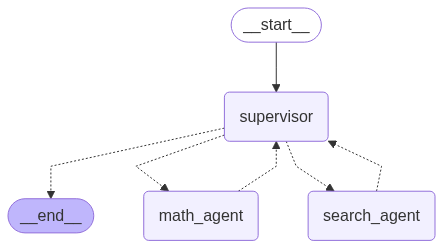

In [150]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [151]:
## 실행

In [152]:
input_question = "(3 * 4) **2 의 결과값은."
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")

(('supervisor:6f0bfb3b-a31b-d038-e901-9d13e7da02aa',), {'agent': {'messages': [AIMessage(content="수학적 계산이 필요하므로 'math_agent'에게 작업을 할당하겠습니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 247, 'total_tokens': 267, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bqb25F8NWitFnLOv8fLdV9Lqo1cYK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='supervisor', id='run--40268ae1-7c68-4c94-a592-501b3f2f57de-0', usage_metadata={'input_tokens': 247, 'output_tokens': 20, 'total_tokens': 267, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
----
📌 RESPONSE {'messages': [HumanMessage(content='(

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


📌 RESPONSE(('supervisor:55bee7bf-5b4a-edcf-469b-dcdd9d71e011',), {'generate_structured_response': {'structured_response': Router(next='__end__', reason='(3 * 4) ** 2의 계산은 3과 4를 곱한 후, 그 결과를 제곱하는 것입니다. 3 * 4는 12이고, 12를 제곱하면 144가 됩니다. 따라서 결과값은 144입니다.')}})
----
 {'messages': [HumanMessage(content='(3 * 4) **2 의 결과값은.', additional_kwargs={}, response_metadata={}, id='2aa1cf51-19bf-471a-8fce-4d6c2cad277a'), HumanMessage(content='(3 * 4) ** 2는 수학적 계산을 포함하므로, 수학 관련 작업을 수행할 수 있는 에이전트에게 요청합니다.', additional_kwargs={}, response_metadata={}, name='supervisor', id='a784ebdc-c1b7-4b46-804c-8945cef5f189'), HumanMessage(content='144.0', additional_kwargs={}, response_metadata={}, name='rag', id='e21b9a33-0a0e-4406-a681-ec2801c6c7d9'), AIMessage(content='FINISH', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 299, 'total_tokens': 301, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,